In [1]:
import seaborn as sns
import pandas as pd
import re, itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import preprocessor as p
from nltk.stem import WordNetLemmatizer
import little_mallet_wrapper
from nltk.tokenize import TweetTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.classify import SklearnClassifier
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
pd.options.display.max_colwidth = 100

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [3]:
# Load the dataset with column names
column_names = ['Text', 'Emotion']
train_data = pd.read_excel("Tweet Emotion Dataset.xlsx", names=column_names)

# Check for missing values
print(train_data.isna().sum())


Text       0
Emotion    0
dtype: int64


In [4]:
train_data

,Text,Emotion
0,@ArcticFantasy I would have almost took offense to this if I actually snapped you,anger
1,@IllinoisLoyalty that Rutgers game was an abomination. An affront to God and man. We must never ...,anger
2,"@CozanGaming that's what lisa asked before she started raging at me, 'can I call you?' heh",anger
3,Sometimes I get mad over something so minuscule I try to ruin somebodies life not like lose your...,anger
4,Sometimes I get mad over something so minuscule I try to ruin somebodies life not like lose your...,anger
...,...,...
341,Common app just randomly logged me out as I was writing the last part of my college essay and lo...,sadness
342,"I'd rather laugh with the rarest genius, in beautiful alliance with his own being, where he kept...",sadness
343,If you #invest in my new #film I will stop asking you to invest in my new film. #concessions #cr...,sadness
344,"Just watched Django Unchained, Other people may frown, but I titter in delight! 2/5",sadness


In [5]:
train_data.duplicated().sum()

0

In [6]:
train_data[train_data.duplicated() == True]

,Text,Emotion


In [7]:
train_data['Emotion'].value_counts()

Emotion
fear       110
anger       83
joy         79
sadness     74
Name: count, dtype: int64

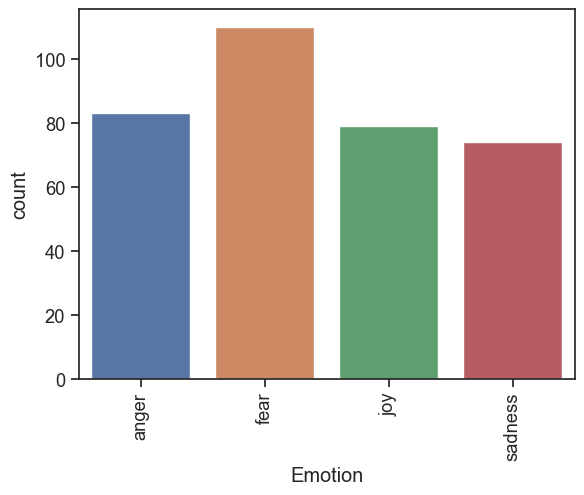

In [8]:
sns.countplot(x=train_data['Emotion'])
plt.xticks(rotation=90)
plt.show()

In [9]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [11]:
print("Before Text Preprocessing")
display(train_data.head()[['Text']])
processed_df = text_preprocessing_platform(train_data, 'Text', remove_stopwords=True)
print("After Text Preprocessing")
display(processed_df.head())


Before Text Preprocessing


,Text
0,arcticfantasy would almost take offense actually snap
1,illinoisloyalty rutgers game abomination affront god man must never speak
2,cozangaming lisa ask start rag call heh
3,sometimes get mad something minuscule try ruin somebodies life like lose job like get federal pr...
4,sometimes get mad something minuscule try ruin somebodies life like lose job like get federal pr...


After Text Preprocessing


,Text,Emotion
0,arcticfantasy would almost take offense actually snap,anger
1,illinoisloyalty rutgers game abomination affront god man must never speak,anger
2,cozangaming lisa ask start rag call heh,anger
3,sometimes get mad something minuscule try ruin somebodies life like lose job like get federal pr...,anger
4,sometimes get mad something minuscule try ruin somebodies life like lose job like get federal pr...,anger


In [ ]:
#removing duplicated values
index = train_data[train_data['Text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [7]:
def clean_text_data(text):
    # Apply preprocessor
    text = p.clean(text)

    # Remove HTML tags and URLs
    text = re.sub(r'<[^>]+>|http[s]?://\S+|http\S+|www\S+|https\S+', '', text)
    
    # Remove punctuation and replace words with multiple consecutive letters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    # Insert a space before all capital letters in the middle of a sentence
    text = re.sub(r"(\w)([A-Z])", r"\1 \2", text)

    # Tokenize the tweet using TweetTokenizer
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    word_tokens = tokenizer.tokenize(text)

    # Stop word removal and length filtering
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    filtered_text = [word for word in word_tokens if word.isalnum() and len(word) > 3 and word.lower() not in stop_words]

    # Lowercase change
    text = ' '.join(filtered_text).lower()

    # Lemmatization using WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    text = ' '.join(lemmatized_words)

    return text

# Assuming 'df' is your DataFrame and 'TweetText' is the column to be cleaned
train_data['CleanedText'] = train_data['Text'].apply(clean_text_data)

# Display the cleaned DataFrame
print(train_data['CleanedText'].head(10))

0                                        would almost took offense actually snapped
1                                 rutgers game abomination affront must never speak
2                                              thats lisa asked started raging call
3    sometimes something minuscule ruin somebody life like lose like federal prison
4    sometimes something minuscule ruin somebody life like lose like federal prison
5                     think must actually working like havent snap chat video today
6                eye dilated hate world right rage thousand fiery dragon need drink
7                               chosen member seat people dole mate elect candidate
8                               chosen member seat people dole mate elect candidate
9                                      please canadian player play player atrocious
Name: CleanedText, dtype: object


In [11]:
processed_df['Text'].duplicated().sum()

6

In [13]:
processed_df[processed_df['Text'].duplicated() == True]

,Text,Emotion
67,anger resentment hatred destroyer fortune today,anger
272,1johndes ball watch rojo header equally dreadful,sadness
280,ccrago dreadful even meet catfish still think,sadness
288,hedgehogdylan would frown bite fold arm every time need assistance someone expect lil,sadness
295,dxfyinggrxvity frustration look elphaba frown aggravation high pitch voice grow,sadness
344,watch django unchain people may frown titter delight twenty-five,sadness


In [15]:
#print some of those rows to check
train_data[train_data['CleanedText'] == train_data.iloc[242]['CleanedText']]

,Text,Emotion,CleanedText
241,@hesham786 that's the spirit #optimism,joy,thats spirit
242,@hesham786 that's the spirit,joy,thats spirit


In [27]:
train_data.drop_duplicates(subset='CleanedText', inplace=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline# Apply text cleaning
train_data['CleanedText'] = train_data['Text'].apply(clean_text_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data['CleanedText'], train_data['Emotion'], test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.to_frame(), y_train)

# Convert resampled X_train back to a Series
X_train_resampled = X_train_resampled['CleanedText']

# Define a pipeline with a TF-IDF vectorizer and a classifier (Naive Bayes, SVM, or Random Forest)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())  # You can replace MultinomialNB with SVC or RandomForestClassifier
])

# Train the model on the resampled data
pipeline.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data['Emotion_Label'] = label_encoder.fit_transform(train_data['Emotion'])


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data['CleanedText'], train_data['Emotion_Label'], test_size=0.2, random_state=42)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Instantiate and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", classification_rep)


Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

       anger       0.82      0.45      0.58        20
        fear       0.44      0.68      0.53        25
         joy       0.40      0.36      0.38        11
     sadness       0.60      0.43      0.50        14

    accuracy                           0.51        70
   macro avg       0.56      0.48      0.50        70
weighted avg       0.57      0.51      0.52        70



In [12]:
# TF IDF vectorizer with adjusted parameters
tfidf_vect = TfidfVectorizer()

# Fit and transform
matrix_tfidf = tfidf_vect.fit_transform(processed_df['Text'])

# Using get_feature_names_out
featureNames = tfidf_vect.get_feature_names_out()

# Data frame for our matrix_tfidf and featureNames
df_tfidf = pd.DataFrame(data=matrix_tfidf.toarray(), columns=featureNames)

# Adding up the importance scores (= TF-IDF scores) for every word.
wordScores = df_tfidf.sum(axis=0)

# Sorting words according to how much they matter in all the tweets
# Sorting them with their overall TF-IDF scores.
top20words = wordScores.sort_values(ascending=False).head(20)

# Print top20words
print(top20words)


get         6.789505
like        5.383700
would       5.308323
go          4.692508
think       4.527916
one         4.352122
people      4.019874
want        3.634914
love        3.552992
look        3.391168
day         3.383057
make        3.196956
watch       3.195772
awful       3.146595
man         2.821896
depress     2.624254
optimism    2.538665
feel        2.504959
two         2.496961
much        2.447746
dtype: float64


In [31]:
# pip install -U imbalanced-learn scikit-learn
from imblearn.over_sampling import RandomOverSampler

# Oversample the training data
ros = RandomOverSampler(random_state=42)
X = train_data['CleanedText'].values.reshape(-1, 1)
y = train_data['Emotion'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

# resource : https://www.kaggle.com/code/titanpointe/cyberbullying-tweets-eda-automl-dl-bert

In [32]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

# resource: https://www.kaggle.com/code/titanpointe/cyberbullying-tweets-eda-automl-dl-bert

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(processed_df['Text'], processed_df['Emotion'], test_size=0.2, random_state=42)

# Use TfidfVectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(processed_df['Text'], processed_df['Emotion'], test_size=0.2, random_state=42)

# Use TfidfVectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create and train the Logistic Regression model
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_regression_classifier.predict(X_test)

# Evaluate the model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic, zero_division=1))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.55      0.67        20
        fear       0.59      0.88      0.71        25
         joy       0.57      0.73      0.64        11
     sadness       0.83      0.36      0.50        14

    accuracy                           0.66        70
   macro avg       0.71      0.63      0.63        70
weighted avg       0.71      0.66      0.64        70



In [18]:
# Create and train the Random Forest model
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train, y_train)


# Make predictions on the test set
y_pred_rf = random_forest_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

Random Forest Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.40      0.55        20
        fear       0.50      1.00      0.67        25
         joy       1.00      0.64      0.78        11
     sadness       1.00      0.29      0.44        14

    accuracy                           0.63        70
   macro avg       0.85      0.58      0.61        70
weighted avg       0.79      0.63      0.61        70



In [19]:
# Create and train the Decision Tree model
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = decision_tree_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=1))

Decision Tree Classification Report:
              precision    recall  f1-score   support

       anger       0.62      0.50      0.56        20
        fear       0.56      0.96      0.71        25
         joy       0.50      0.36      0.42        11
     sadness       1.00      0.21      0.35        14

    accuracy                           0.59        70
   macro avg       0.67      0.51      0.51        70
weighted avg       0.66      0.59      0.55        70



In [20]:
# Create and train the Support Vector Machines model
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the model
print("Support Vector Machines Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=1))

Support Vector Machines Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.30      0.46        20
        fear       0.49      0.92      0.64        25
         joy       0.73      0.73      0.73        11
     sadness       0.83      0.36      0.50        14

    accuracy                           0.60        70
   macro avg       0.76      0.58      0.58        70
weighted avg       0.74      0.60      0.57        70

